# 1. Importações

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, log_loss
import joblib

# 2. Carregar dados

In [ ]:
X = pd.read_csv('features_preprocessed.csv')
y = pd.read_csv('target.csv')
if 'target' not in y.columns:
    y = y.iloc[:, 0]
print(f"Shape X: {X.shape}, y: {y.shape}")

Shape X: (53759, 26), y: (53759, 1)


# 3. Divisão em treino e teste

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Treino: {X_train.shape}, Teste: {X_test.shape}")

Treino: (43007, 26), Teste: (10752, 26)


# 4. Grid Search para XGBoost

In [ ]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.01]
}
base_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)
grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    cv=3,
    scoring='roc_auc',
    verbose=1,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)
print("Melhores parâmetros:", grid_search.best_params_)
best_model = grid_search.best_estimator_

Fitting 3 folds for each of 8 candidates, totalling 24 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:32:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Melhores parâmetros: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}


# 5. Avaliação do Modelo

In [ ]:
# Previsões e probabilidades
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print(f"Log Loss: {log_loss(y_test, y_proba):.4f}")


              precision    recall  f1-score   support

           0       0.95      1.00      0.97     10155
           1       0.56      0.07      0.13       597

    accuracy                           0.95     10752
   macro avg       0.75      0.54      0.55     10752
weighted avg       0.93      0.95      0.93     10752

ROC AUC: 0.7639
Confusion Matrix:
[[10120    35]
 [  553    44]]
Log Loss: 0.1795


# 6. Importância das Features

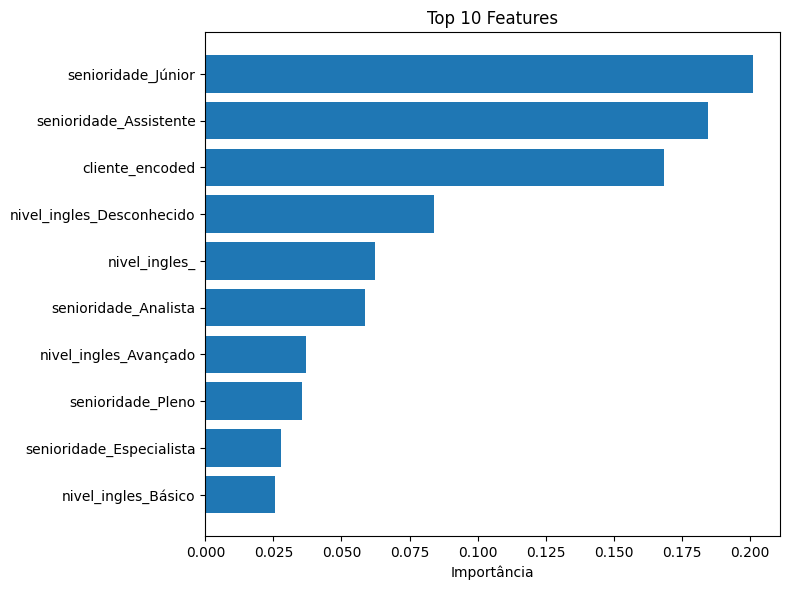

In [ ]:
import matplotlib.pyplot as plt

# Obter importâncias
importance = best_model.feature_importances_
features = X.columns

# Combinar e ordenar
imp_df = pd.DataFrame({
    'feature': features,
    'importance': importance
}).sort_values(by='importance', ascending=False).head(10)

# Plot
plt.figure(figsize=(8, 6))
plt.barh(imp_df['feature'][::-1], imp_df['importance'][::-1])
plt.xlabel('Importância')
plt.title('Top 10 Features')
plt.tight_layout()
plt.show()

# 7. Salvando o Modelo Treinado

In [ ]:
model_path = 'xgb_model.joblib'
joblib.dump(best_model, model_path)
print(f"Modelo XGBoost salvo em: {model_path}")

Modelo XGBoost salvo em: xgb_model.joblib
